AutoGluon - Predicción de ventas (tn) por producto para febrero 2020

In [35]:
# 📦 1. Importar librerías
import pandas as pd

In [36]:
# 💬 Instalar AutoGluon si es necesario
#%pip install autogluon.timeseries

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from sklearn.preprocessing import StandardScaler

In [37]:
# 📄 2. Cargar datasets
df_sellin = pd.read_csv("../data/sell-in.txt", sep="\t")
df_productos = pd.read_csv("../data/tb_productos.txt", sep="\t")

In [38]:
# 📄 Leer lista de productos a predecir
with open("../data/product_id_apredecir201912.txt", "r") as f:
    product_ids = [int(line.strip()) for line in f if line.strip().isdigit()]

In [39]:
# 🧹 3. Preprocesamiento
# Convertir periodo a datetime
df_sellin['timestamp'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')

In [40]:
# Filtrar hasta dic 2019 y productos requeridos
df_filtered = df_sellin[
    (df_sellin['timestamp'] <= '2019-12-01') &
    (df_sellin['product_id'].isin(product_ids))
]

In [41]:
# Agregar tn por periodo, cliente y producto
df_grouped = df_filtered.groupby(['timestamp', 'customer_id', 'product_id'], as_index=False)['tn'].sum()

In [42]:
# Agregar tn total por periodo y producto
df_monthly_product = df_grouped.groupby(['timestamp', 'product_id'], as_index=False)['tn'].sum()

In [43]:
# Agregar columna 'item_id' para AutoGluon
df_monthly_product['item_id'] = df_monthly_product['product_id']

In [44]:
# Crear características de lag y rolling
for lag in [1, 3, 6, 12]:
    df_monthly_product[f'tn_lag_{lag}'] = df_monthly_product.groupby('product_id')['tn'].shift(lag)

df_monthly_product['tn_rolling_mean_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).mean()
df_monthly_product['tn_rolling_std_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).std()

In [45]:
# Incorporar características estáticas de tb_productos
df_monthly_product = df_monthly_product.merge(df_productos, on='product_id', how='left')

# Normalizar características numéricas
scaler = StandardScaler()
numeric_cols = ['tn_lag_1', 'tn_lag_3', 'tn_lag_6', 'tn_lag_12', 'tn_rolling_mean_3', 'tn_rolling_std_3']
df_monthly_product[numeric_cols] = scaler.fit_transform(df_monthly_product[numeric_cols].fillna(0))

In [46]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_rolling_mean_3,tn_rolling_std_3,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,934.77222,20001,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,HC,ROPA LAVADO,Liquido,ARIEL,3000
1,2017-01-01,20002,550.15707,20002,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,HC,ROPA LAVADO,Liquido,LIMPIEX,3000
2,2017-01-01,20003,1063.45835,20003,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,475
3,2017-01-01,20004,555.91614,20004,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,240
4,2017-01-01,20005,494.27011,20005,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22677,2019-12-01,21263,0.01270,21263,-0.404105,-0.391136,-0.369472,-0.321898,-0.433281,-0.303044,PC,CABELLO,SHAMPOO,VICHY,250
22678,2019-12-01,21265,0.05007,21265,-0.403841,-0.391089,-0.369126,-0.322445,-0.433178,-0.302692,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22679,2019-12-01,21266,0.05121,21266,-0.403832,-0.390996,-0.369116,-0.322445,-0.433064,-0.302720,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22680,2019-12-01,21267,0.01569,21267,-0.404042,-0.391079,-0.369062,-0.322445,-0.433041,-0.302809,PC,PIEL1,Cara,NIVEA,250


In [ ]:
df_prod_static = (
    df_productos
    .rename(columns={'product_id': 'item_id'})
    .drop_duplicates(subset=['item_id'])
)  # dejamos item_id como columna

ts_data = TimeSeriesDataFrame.from_data_frame(
    df_monthly_product,
    id_column='item_id',
    timestamp_column='timestamp',
    static_features_df=df_prod_static
)


# # ⏰ 4. Crear TimeSeriesDataFrame
# ts_data = TimeSeriesDataFrame.from_data_frame(
#     df_monthly_product,
#     id_column='item_id',
#     timestamp_column='timestamp'
# )

In [48]:
# # Completar valores faltantes
ts_data = ts_data.fill_missing_values()

In [52]:
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    freq='MS',
    eval_metric='WQL'
)

predictor.fit(
    train_data=ts_data,
    num_val_windows=2,
    time_limit=60*60
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250713_235722'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       9.07 GB / 31.71 GB (28.6%)
Disk Space Avail:   203.76 GB / 952.62 GB (21.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency 'MS'.
Provided t

In [53]:
# 3.1) Sólo data como argumento
future_template = predictor.make_future_data_frame(ts_data)

# 3.2) Covariables “a mano”
future_rows = []
for item_id in product_ids:
    last = df_monthly_product[df_monthly_product['item_id']==item_id].iloc[-1]
    future_rows.append({
        'item_id': item_id,
        'timestamp': pd.Timestamp('2020-02-01'),
        'month':  2,
        'year':   2020,
        'tn_lag_1':          last['tn_lag_1'],
        'tn_lag_3':          last['tn_lag_3'],
        'tn_lag_6':          last['tn_lag_6'],
        'tn_lag_12':         last['tn_lag_12'],
        'tn_rolling_mean_3': last['tn_rolling_mean_3'],
        'tn_rolling_std_3':  last['tn_rolling_std_3'],
    })
df_future_covars = pd.DataFrame(future_rows)

# 3.3) Merge plantilla + covariables
future_covars = future_template.merge(
    df_future_covars,
    on=['item_id','timestamp'],
    how='left'
)

# 3.4) A TimeSeriesDataFrame
ts_future_covars = TimeSeriesDataFrame.from_data_frame(
    future_covars,
    id_column='item_id',
    timestamp_column='timestamp'
).fill_missing_values(method='ffill', value=0)

data with frequency 'IRREG' has been resampled to frequency 'MS'.


In [54]:
# # 🔮 6. Generar predicción
# forecast = predictor.predict(ts_data)

# 4) Predecir
forecast = predictor.predict(
    data=ts_data,
    known_covariates=ts_future_covars
)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [3]:
forecast

NameError: name 'forecast' is not defined

In [56]:
predictor.leaderboard(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.184757,-0.170108,8.445318,8.186302,2.163855,13
1,ChronosFineTuned[bolt_small],-0.185182,-0.179198,1.331375,0.746127,519.406980,8
2,TemporalFusionTransformer,-0.186853,-0.176993,0.780059,0.560226,477.994109,9
3,TiDE,-0.193636,-0.228854,0.803211,0.584704,369.298484,12
4,DeepAR,-0.205243,-0.185993,0.851063,0.549041,138.901439,10
5,PatchTST,-0.209386,-0.186348,0.427690,0.251341,71.897259,11
6,ChronosZeroShot[bolt_base],-0.211922,-0.190460,5.549410,5.597750,4.749868,7
7,AutoETS,-0.215147,-0.201045,3.311060,4.652220,4.785645,6
8,DynamicOptimizedTheta,-0.221798,-0.203868,8.255221,1.158553,3.925970,5
9,DirectTabular,-0.231603,-0.243576,0.159915,0.144372,28.682096,3


data with frequency 'IRREG' has been resampled to frequency 'MS'.


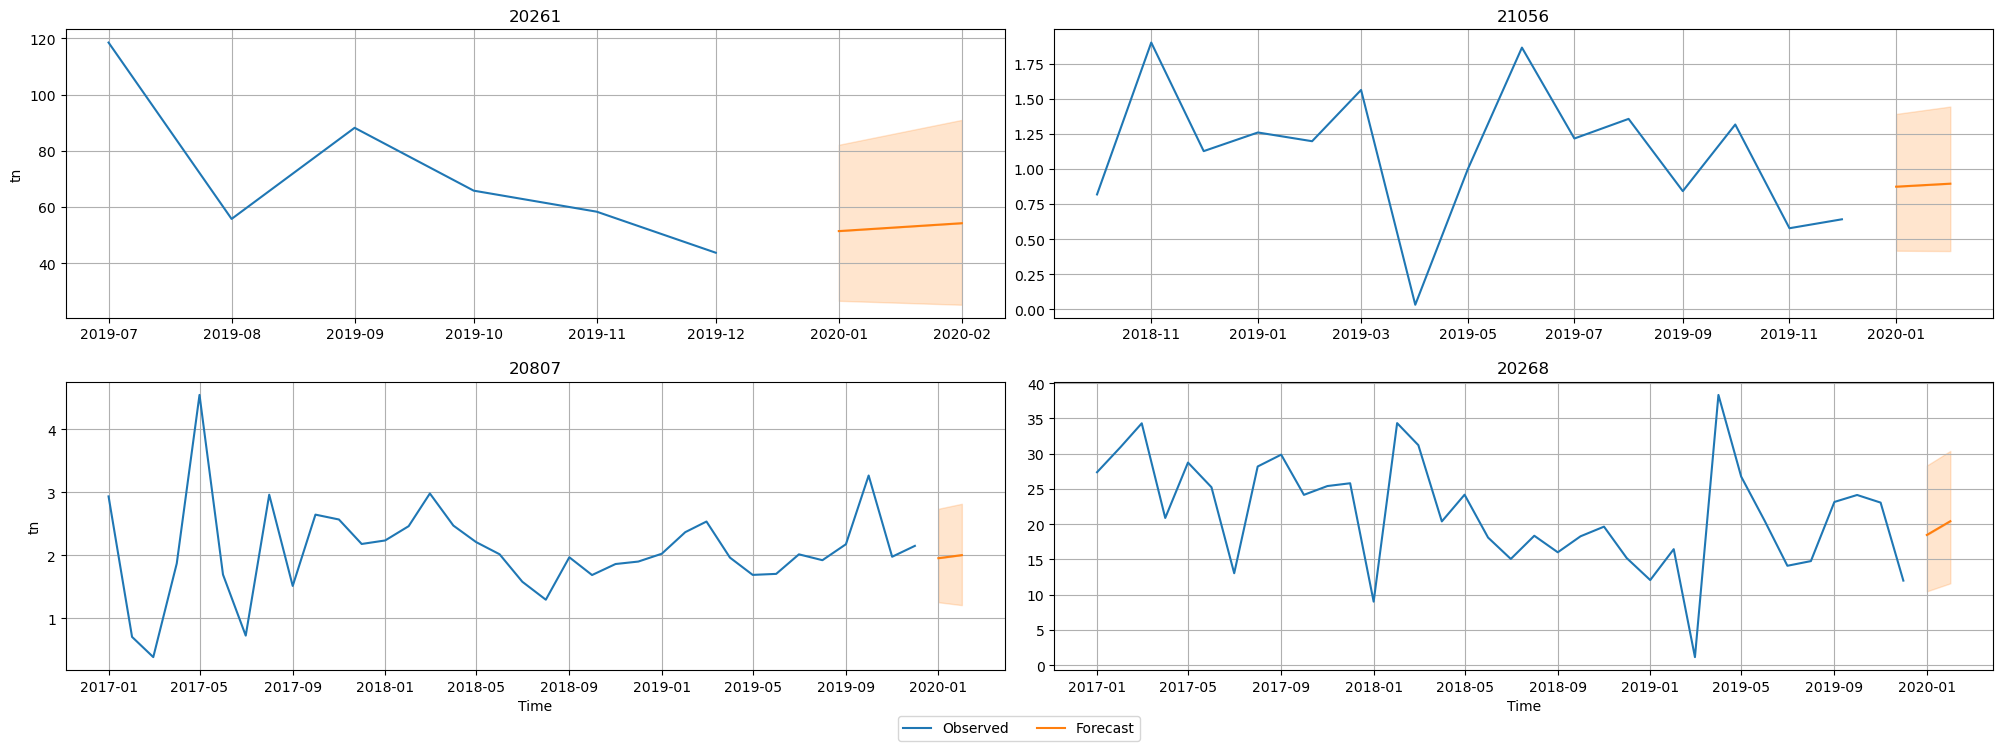

In [57]:
predictor.plot(ts_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [58]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['mean'].reset_index()
print(forecast_mean.columns)

Index(['item_id', 'timestamp', 'mean'], dtype='object')


In [59]:
# Tomar solo item_id y la predicción 'mean'
resultado = forecast['mean'].reset_index()[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['mean'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']


In [60]:
resultado

,product_id,tn
1,20001,1352.145783
3,20002,1080.898038
5,20003,721.620887
7,20004,534.144696
9,20005,502.292647
...,...,...
1551,20962,2.877467
1553,20975,2.562340
1555,20995,2.410405
1557,21087,0.877935


In [61]:
# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_lhv10.csv", index=False)
resultado.head()

,product_id,tn
1,20001,1352.145783
3,20002,1080.898038
5,20003,721.620887
7,20004,534.144696
9,20005,502.292647


In [2]:
# Extraer predicción media y filtrar febrero 2020
# forecast_mean = forecast['0.6'].reset_index()
# print(forecast_mean.columns)

# Tomar solo item_id y la predicción 'mean'
resultado = forecast['0.6'].reset_index()[['item_id', '0.6']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['0.6'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', '0.6']]
resultado.columns = ['product_id', 'tn']

# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_lhv11.csv", index=False)
resultado.head()

NameError: name 'forecast' is not defined

In [ ]:
# from autogluon.common import space

# # ⚙️ 5. Definir y entrenar predictor
# predictor = TimeSeriesPredictor(
#     prediction_length=2,
#     target='tn',
#     eval_metric="MASE",
#     freq='MS'  # Frecuencia mensual (Month Start), 
# )

# predictor.fit(
#     ts_data,
#     presets="best_quality",    
#     hyperparameters={
#         "DeepAR": {
#             "hidden_size": space.Int(20, 100),
#             "dropout_rate": space.Categorical(0.1, 0.3),
#         },
#         "Theta": [
#             {"decomposition_type": "additive"},
#             {"seasonal_period": 1},
#         ],
#         "Chronos": [
#             {
#                 "model_path": "bolt_small", 
#                 "ag_args": {"name_suffix": "ZeroShot"}
#             },
#             {
#                 "model_path": "bolt_small", 
#                 "fine_tune": True, 
#                 "ag_args": {"name_suffix": "FineTuned"}
#             },
#             {
#                 "model_path": "bolt_small",
#                 "covariate_regressor": "CAT",
#                 "target_scaler": "standard",
#                 "ag_args": {"name_suffix": "WithRegressor"},
#             },            
#         ]        
#     },
#     enable_ensemble=True,
#     time_limit=3600
# )

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250703_023005'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       8.57 GB / 31.71 GB (27.0%)
Disk Space Avail:   176.32 GB / 952.62 GB (18.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {},
                     'Theta': [{'decomposition_type': 'additive'},
                               {'seasonal_period': 1}]},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_m